### Protein Composition Statistics

The analysis functions are located in `./indels/proteins.py`, which draws general functions from `./indels/ind.py`

In [1]:
# Perform the initialization and imports
import sys
import pickle
import re
import os
import csv
import argparse
import math
import pprint

from string import ascii_lowercase
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO, AlignIO
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio.Emboss.Applications import NeedleallCommandline

# Demand Python 3.
if sys.version_info[0] < 3:
    print("Python 3 is required, but you are using Python %i.%i.%i") % (
        sys.version_info[0], sys.version_info[1], sys.version_info[2])
    sys.exit(1)

If the InDelScanner directory is not on your path, modify the `indels_path` variable to point to it.

In [2]:
# Retrieve the specific functions from ind and proteins.py
indels_path="/home/maya/InDelScanner"  # /PATH/TO/InDelScanner
if indels_path not in sys.path:
    sys.path.append(indels_path)
from indels.ind import trim_read, findEnds, endMatch, findGap, gapAlign

Specify the working directory: this should be where your input files are located.

In [3]:
os.chdir("/mnt/c/Users/Maya/Dropbox/mek_results")

## Experiment design
In this experiment, the peptide libraries were split by FACS into three gates: high, medium and low. This DNA was isolated by PCR and sequenced in the same Illumina run. Due to initial low covereage of the "low" gate, this fraction was re-sequenced to yield "low-v2". The next cell loads the alignment dictionaries from both sequencing runs and combines into one Counter class.
Because of re-sequencing in the low fraction, we choose to combine the counts from both sequencing runs to take advantage of the total higher coverage.

### Library composition
The peptide libraries were randomized in the form MPKKKXTPXQXNXAPDGS; the randomized X positions are 6, 9, 11 and 13. Additionally, there is a possible insertion of A at position 7a (after TP) and a potential randomized X insertion at postion 8a. X may be any one of ADFGIKLMPVWY.

In [4]:
with open('Remkes_protein.p', 'rb') as f:
    all_ref = pickle.load(f)
with open('Remkes_protein_low.p', 'rb') as f:
    low = pickle.load(f)

all_ref['mek']['low-v2'] = low['mek']['low-v2']

mek = {}
for fraction in ['high', 'med']:
    mek[fraction] = Counter(all_ref['mek'][fraction])
mek['low-t'] = Counter(all_ref['mek']['low']) + Counter(all_ref['mek']['low-v2'])

Start inspection of the dataset by looking for most enriched variants in each gate and checking their presence in the other gates. This treats the NGS dataset as a way to find the most active variants in a straighforward way - the most active variants should:
* have a strong enrichment for the top gate, with high counts in 'high' gate and low to zero counts in the 'low' gate; though there will be some bleed-over of signal due to errors during FACS
* be highly present in the 'high' gate

Output files: Top hits - FRACTION NAME.csv

In [5]:
def top_variant_distribution(mek, fraction, filename):

    top = mek[fraction].most_common(200)
    with open(filename, 'w') as f:
        csv_writer = csv.writer(f, delimiter=',')
        csv_writer.writerow(['Mutation', 'High', 'Medium', 'Low'])
        for pair in top:
            protein = pair[0]
            csv_writer.writerow([protein, mek['high'][protein], mek['med'][protein], mek['low-t'][protein]] )

top_variant_distribution(mek, 'high', 'Top hits - High.csv')
top_variant_distribution(mek, 'med', 'Top hits - Med.csv')
top_variant_distribution(mek, 'low-t', 'Top hits - Low.csv')

df_top = pd.read_csv('Top hits - High.csv')
df_top.head(15)

,Mutation,High,Medium,Low
0,6L/7aI/8aA/9L/11F/13M,1185,33,6
1,6F/7aP/9W/11L/13M,903,81,15
2,6L/7aF/9L/11I/13I,899,2,8
3,6A/7aI/8aA/9L/11L/13I,893,3,19
4,6W/7aI/9F/11L/13V,880,34,20
5,6A/7aP/8aA/9L/11V/13W,872,0,18
6,6L/7aI/8aA/9M/11W/13W,871,24,18
7,6V/7aP/8aA/9F/11F/13M,869,1,5
8,6A/7aK/9L/11L/13W,859,0,14
9,6A/7aI/8aA/9L/11V/13M,852,0,26


## Single position enrichments
The original protein before sorting is balanced: each randomized position contains an equal amount of each amino acid, as far as technically possible.

If a particular amino acid (for example, L in position 9) is adaptive for strong binding, the 'high' gate of the library should be enriched for that amino acid in that position. Hence, a deviation from balanced composition at any one position indicates that the enriched amino acids promote active binding while those depleted (and correspondingly enriched in the 'low' gate) are disruptive to binding.

In [6]:
def convert_variant_to_dict(mutation_string):
    """
    Convert a string of positions deviating from WT into a dictionary listing the status at all positions
    Input: string of the format '6A/7aK/9L' etc.
    Output: dictionary listing AA at each position, including WT
    """
    wt = {'6': 'P', '7a': 'Δ', '8a': 'Δ', '9': 'I', '11': 'L', '13': 'P'}
    
    mutation_list = mutation_string.split('/')
    m_by_pos = {point_mutation[:-1] : point_mutation[-1] for point_mutation in mutation_list}
    
    for position in wt.keys():   # need to do it this way so that WT positions are included
        try:
            m_by_pos[position]
        except KeyError:
            m_by_pos[position] = wt[position]

    return m_by_pos


def passes_restriction(m_by_pos, restrict):
    """
    Helper function in case we are looking at enrichment with certain positions fixed. 'restrict' is a dictionary of the form
    restrict[position] = ['A', 'L'] etc.
    """
    wt = {'6': 'P', '7a': 'Δ', '8a': 'Δ', '9': 'I', '11': 'L', '13': 'P'}
    
    if restrict:
        for position, allowed_aa in restrict.items():
            try:
                aa = m_by_pos[position]
            except KeyError:
                aa = wt[position]
            
            if aa not in allowed_aa:
                return False

    return True


def single_fraction_enrichment(mek, fraction, cutoff, restrict = False, proportion=True):
    """
    Input: the dictionary containing a Counter for each fraction
    Output: dictionary with data aggregated by position, format: point_distrubution[pos][aa] = int
    """
    valid_aa = {'A', 'D', 'F', 'G', 'I', 'K', 'L', 'M', 'P', 'V', 'W', 'Y', 'Δ'}
    point_distribution = {pos: {aa: 0 for aa in valid_aa} for pos in ['6', '7a', '8a', '9', '11', '13']}
    wt = {'6': 'P', '7a': 'Δ', '8a': 'Δ', '9': 'I', '11': 'L', '13': 'P'}

    # the input data is formatted as mek['fraction'][mutation_string] = integer
    # each mutation is a collection of mutations of the format Integer + single letterAA code, separated by '/'
    # we are querying this by position, so need to split by position and convert into a new Counter:
    # mek['fraction']['position']['amino_acid'] = integer
    
    for mutation_string, count in mek[fraction].items():
        if count > cutoff:  # ignore the frameshifts and such coming from noise
            
            # m_by_pos[position] = AA
            m_by_pos = convert_variant_to_dict(mutation_string)
            # check the mutations is one we're interested in
            observed_aa = set(m_by_pos.values())
            if not observed_aa.issubset(valid_aa):
                continue
            
            # in case we are considering relative enrichement, where some position is fixed:
            # the constrains has the form of a dictionary with allowed amino acids in tha tposition
            if not passes_restriction(m_by_pos, restrict):
                continue                

            # for the valid AAs, add counts to position proportions
            if proportion:
                for pos, aa in m_by_pos.items():  # need to do it this way so that WT positions are included
                    point_distribution[pos][aa] += count
            else:
                for pos, aa in m_by_pos.items():  # need to do it this way so that WT positions are included
                    point_distribution[pos][aa] += 1
    return point_distribution

In [7]:
# Set palette and the order of amino acids for meaningful colors
pal = sns.color_palette("tab20")[:13]
pal[12] = (0.9, 0.9, 0.9) # set deletion to gray
aa_order = ['A','G','P','Y','D','K','M','V','I','L','F','W','Δ']

In [8]:
def make_composition_plot_per_position(df_point, title_text, filename):
    sns.set_palette(pal)
    cols = df_point.columns.values.tolist()  
    aa_all = df_point.index.values.tolist()  # have the same labels and colorscheme for all charts

    fig = plt.figure(figsize=(13,2.5))
    fig.suptitle(title_text)

    axes = list(range(len(cols)))  # make axes with a column for each position

    for i in range(len(cols)):
        axes[i] = fig.add_subplot(1, len(cols), i + 1)
        plt.pie(df_point[cols[i]], startangle=90)
        axes[i].set_title(cols[i])

    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in pal]
    fig.legend(markers, aa_all, numpoints=1, loc='center left', ncol=2)
    fig.patch.set_facecolor('white')
    
    plt.savefig(filename + '.svg')

    plt.show()

In [9]:
# Now use the distribution in this fraction to make plots
high = single_fraction_enrichment(mek, 'high', 10)
df_point_high = pd.DataFrame.from_dict(high).reindex(aa_order)
df_point_high

,6,7a,8a,9,11,13
A,318033,162796,2045200,151025,143375,348236
G,269975,173540,0,108944,110428,227625
P,395032,525780,0,315651,150232,308007
Y,289297,218236,0,227773,194274,147867
D,156812,80272,0,143520,119528,178984
K,339340,305212,0,228953,129386,248349
M,407766,206904,0,489773,318561,578141
V,353316,242767,0,273265,379452,534812
I,286203,843938,0,643111,918900,661938
L,745630,913516,0,1160722,1272684,387858


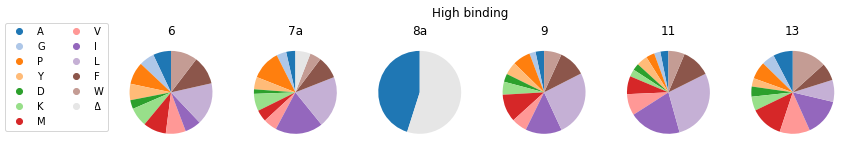

In [10]:
make_composition_plot_per_position(df_point_high, 'High binding', 'High_no_filter')

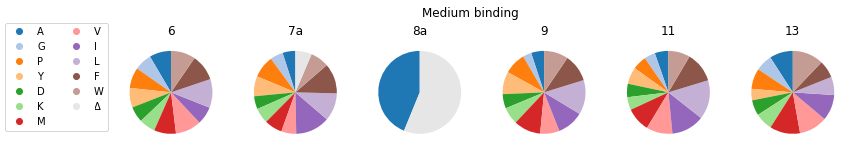

In [11]:
med = single_fraction_enrichment(mek, 'med', 3)
df_point_med = pd.DataFrame.from_dict(med).reindex(aa_order)
make_composition_plot_per_position(df_point_med, 'Medium binding', 'Medium_no_filter')

In [12]:
df_point_med

,6,7a,8a,9,11,13
A,248133,146731,1285190,147755,156452,267164
G,199498,146418,0,98666,125538,191899
P,235684,255692,0,249962,161190,234226
Y,223970,229383,0,257655,192167,131231
D,180242,147406,0,163187,153534,176399
K,185234,176460,0,196744,146802,201529
M,250686,203460,0,308064,277147,347002
V,295608,170975,0,220565,299249,323835
I,204506,392651,0,302866,377069,296219
L,328181,319317,0,394712,448815,207928


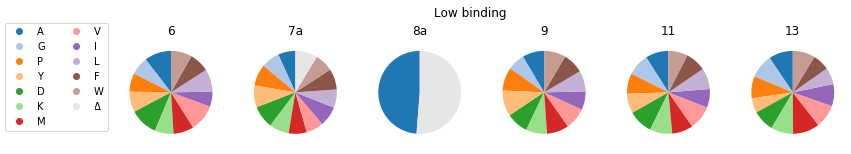

In [13]:
low = single_fraction_enrichment(mek, 'low-t', 3)
df_point_low = pd.DataFrame.from_dict(low).reindex(aa_order)
make_composition_plot_per_position(df_point_low, 'Low binding', 'Low_no_filter')

In [86]:
df_low_sd = df_point_low.replace(0, np.nan)/(df_point_low.sum()/df_point_low.astype(bool).sum(axis=0))
(df_point_low.replace(0, np.nan)/df_point_low.sum())
#df_low_sd.std()

,6,7a,8a,9,11,13
A,0.104466,0.067603,0.487683,0.085113,0.089963,0.094242
G,0.070974,0.071863,NaN,0.067075,0.085625,0.093073
P,0.072049,0.083941,NaN,0.090964,0.080058,0.085876
Y,0.079968,0.085617,NaN,0.100820,0.076678,0.057351
D,0.109101,0.088132,NaN,0.085507,0.095089,0.083753
K,0.073338,0.076973,NaN,0.082082,0.087298,0.086709
M,0.079526,0.070303,NaN,0.085518,0.082340,0.104546
V,0.105192,0.067487,NaN,0.084951,0.093789,0.090620
I,0.057986,0.078142,NaN,0.071483,0.072250,0.085896
L,0.088029,0.071091,NaN,0.081107,0.081823,0.065299


In [80]:
(df_point_low.replace(0, np.nan).std()/df_point_low.replace(0, np.nan).mean())

6     0.187747
7a    0.096733
8a    0.034837
9     0.102243
11    0.086635
13    0.165163
dtype: float64

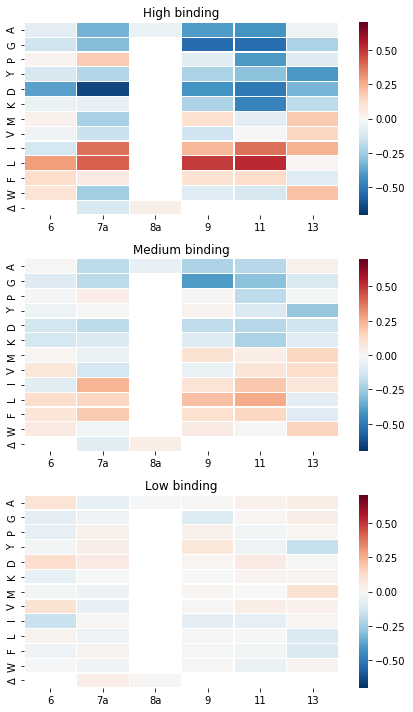

In [33]:
fig, axes = plt.subplots(3, 1, figsize=(6,10))

dfs = [df_point_high, df_point_med, df_point_low]
titles = ['High binding', 'Medium binding', 'Low binding']

for i in range(len(dfs)):
    # normalise the df
    log_df = (dfs[i]/(dfs[i].sum()/dfs[i].astype(bool).sum(axis=0))).apply(np.log10)   
    sns.heatmap(log_df, vmin=-0.7, vmax=0.7, linewidths=0.2, ax=axes[i], cmap="RdBu_r")
    axes[i].set_title(titles[i])

plt.tight_layout()
plt.savefig('Single_heatmaps.svg')
plt.show()

### How many variants are there?

In [ ]:
h_f = Counter({x : mek['high'][x] for x in mek['high'] if mek['high'][x] >= 10})
m_f = Counter({x : mek['med'][x] for x in mek['med'] if mek['med'][x] >= 3})
l_f = Counter({x : mek['low-t'][x] for x in mek['low-t'] if mek['low-t'][x] >= 3})

print('Variants in low gate, seen 3+ times:', len(l_f))
print('Variants in medium gate, seen 3+ times:', len(m_f))
print('Variants in high gate, seen 10+ times:', len(h_f))
print()
print('Variants in both low and medium:', len(l_f) + len(m_f) - len(l_f + m_f))
print('Variants in both low and high:', len(l_f) + len(h_f) - len(l_f + h_f))
print('Variants in both medium and high:', len(h_f) + len(m_f) - len(h_f + m_f))
print()
print('Total unique variants:', len(l_f + m_f + h_f))

Now include filtering for variants with the correct codons

In [ ]:
def filtered_counter(mek, fraction, cutoff, restrict = False):
    """
    Input: the dictionary containing a Counter for each fraction
    Output: dictionary with data aggregated by position, format: point_distrubution[pos][aa] = int
    """
    valid_aa = {'A', 'D', 'F', 'G', 'I', 'K', 'L', 'M', 'P', 'V', 'W', 'Y', 'Δ'}
    variants = defaultdict(int)
    wt = {'6': 'P', '7a': 'Δ', '8a': 'Δ', '9': 'I', '11': 'L', '13': 'P'}
    
    for mutation_string, count in mek[fraction].items():
        if count > cutoff:  # ignore the frameshifts and such coming from noise
            
            # m_by_pos[position] = AA
            m_by_pos = convert_variant_to_dict(mutation_string)
            # check the mutations is one we're interested in
            observed_aa = set(m_by_pos.values())
            if not observed_aa.issubset(valid_aa):
                continue
          
            variants[mutation_string] += count
    
    return Counter(variants)

In [ ]:
h = filtered_counter(mek, 'high', 10)
print('Designed variants in high gate, seen 10+ times:', len(h))

In [ ]:
m = filtered_counter(mek, 'med', 3)
print('Designed variants in medium gate, seen 3+ times:', len(m))

In [ ]:
l = filtered_counter(mek, 'low-t', 3)
print('Designed variants in low gate, seen 3+ times:', len(l))

In [ ]:
print('Designed variants in both low and medium:', len(l) + len(m) - len(l + m))
print('Designed ariants in both low and high:', len(l) + len(h) - len(l + h))
print('Designed ariants in both medium and high:', len(h) + len(m) - len(h + m))

print()
print('Total unique variants:', len(l + m + h))

### Shannon Entropy (SE) at single positions
We often ask "How conserved is a position in an amino acid alignment?" Shannon entropy is a concept coming from information theory that gives a numerical description of conservation, with range from 0 (completely conserved) and 1 (no conservation). While the use of SE in protein sciece derives from analysis of protein sequence alignments, we can adapt SE for analysis of conservation in these sorted libraries by constructing "virtual multiple sequence alignment": each detected variant that has a count X above the cutoff is counted X-times, to weigh the amino acid distribution per position according to how frequent variants are. Therefore, the most strongly enriched variants also have the strongest effect on SE.

#### SE definitions
Single position Shannon entropy is defined as $$S_i = - \sum_{a=1}^{N} f_a \cdot log_N(f_a)$$
Frequency of amino acids: $$f_a = \frac{p + c_a}{n + 1}$$where $c_a$ is the number of amino acids $a$ at that position, $n$ is the total number of sequences and $p = \frac{1}{N}$ for alphabet of size $N$; here $N$ equals 2 (position 8a), 12 (positions 6, 9, 11 and 13) or 13 (positon 7a). 

#### Expectation: low conservation
In the graphs above we see that there is a shift in the distribution between the low, medium and high gates, but no amino acid dominates the outcome in the high gate. Hence, we expect that the conservation in terms of SE will be close to 1.

In [ ]:
def Shannon_par(point_distribution, position):
    """
    Helper function to calculate Shannon pseudo-count
    :param point_distribution: calculated by single_fraction_enrichment
    :param position:
    :return:
    """
    N = 0  # size of amino acid alphabet
    n = 0  # total number of observed variants
    for aa, count in point_distribution[position].items():
        if count > 0:
            N += 1
            n += count

    p = 1/N

    return {'p': p, 'N': N, 'n': n}


def position_entropy(point_distribution, position):
    """
    Shannon entropy of a single position in protein alignment.
    :param point_distribution: calculated by single_fraction_enrichment
    :param position:
    :return:
    """
    # point_proportions has the structure point_proportions[pos][aa] = count
    S_i = 0
    par = Shannon_par(point_distribution, position)

    for aa, count in point_distribution[position].items():
        if count == 0:
            continue
        else:
            f_a = (par['p'] + count) / (par['n'] + 1)
            S_i -= f_a * math.log(f_a, par['N'])

    return S_i


In [ ]:
shannon_entropy_single = {}
for position in single_enrichment_high.keys():
    shannon_entropy_single[position] = position_entropy(single_enrichment_high, position)
pd.DataFrame.from_dict(shannon_entropy_single, orient='index', columns=['Shannon Entropy'])

## Quantifying conservation

So far we have treated mutations at each randomized position independently, under the model that the effect mutations at different position will be exactly additive. The alternative scenario is one where mutations are not additive, dubbed epistasis.

#### Hypothesis: little epistasis
Here we are investigating the effect of mutations on binding of MAPKKK on the target peptide on MEK-1; since this is a short peptide where each amino acid binds a different spot in the binding groove, the expectation is that the positions are largely independent and there is little overall epistasis. There may be some epistasis coming from the presence or absence of insertions at positions 7a and 8a, since they will affect the positioning of the rest of the peptide.

### Shannon Entropy and Mutual Information
Mutual information (M) between two positions ($i$ and $j$) is a commonly accepted method of quantifying epistasis between positions as a whole, and is defined as the difference between the Shannon entropy of individual positions and their joint entropy:

Mutual information: $M = S_i + S_j - 2S_{ij}$

The joint SE is defined analogously to single position entropy:
$$S_{ij} = -\sum_{a=1}^{N} \sum_{b=1}^{N}   f_{ab} \cdot log_{N_a N_b}{f_{ab}}$$
That is, the logarithm of $f_{ab}$ is taken with base $N_a N_b$.

The joint amino acid frequency is defined as $$f_{ab} = \frac{p + c_{ab}}{n + 1}$$
where $c_{ab}$ is the count of sequences with amino acids $a$, $b$ in the positions of interest. Similarly to single position, $p = \frac{1}{N_a N_b}$, where $N_a$ and $N_b$ refer to the number of sequences containing amino acids $a$ and $b$ respectively.

#### Interpretation
* Fully conserved position: **0**
* No preference for amino acid: **1**

In [ ]:
def overall_covariation(mek, fraction, cutoff, restrict = False):
    """
    Input: mek['fraction']['variant'] = count
    """
    valid_aa = {'A', 'D', 'F', 'G', 'I', 'K', 'L', 'M', 'P', 'V', 'W', 'Y', 'Δ'}
    wt = {'6': 'P', '7a': 'Δ', '8a': 'Δ', '9': 'I', '11': 'L', '13': 'P'}
    positions = wt.keys()

    covariation = {pos_a: {aa: {pos_b: {aa: 0 for aa in valid_aa}
                                for pos_b in wt.keys()} for aa in valid_aa} for pos_a in wt.keys()}
    
    for mutation_string, count in mek[fraction].items():
        if count > cutoff:  # ignore the frameshifts and such coming from noise
            
            # m_by_pos[position] = AA
            m_by_pos = convert_variant_to_dict(mutation_string)
            
            # Check that the variant is one of the expected mutations and not noise
            observed_aa = set(m_by_pos.values())
            if not observed_aa.issubset(valid_aa):
                continue
            
            # in case we are considering relative enrichement, where some position is fixed:
            # the constrains has the form of a dictionary with allowed amino acids in tha tposition
            if not passes_restriction(m_by_pos, restrict):
                continue                

            # for the valid AAs, add counts to position proportions
            for pos_a in wt.keys():
                for pos_b in wt.keys():
                    covariation[pos_a][m_by_pos[pos_a]][pos_b][m_by_pos[pos_b]] += count

    return covariation


def export_covariation_csv(mek, fraction, cutoff):
    """
    Summarize single position preferences and export it into a CSV file.
    :param background: 'mek'
    :param frac: high, med or low
    :param cutoff: depends on the gate
    :return:
    """

    with open('.'.join(('Covariation', fraction, 'csv')), 'w') as f:
        covar = overall_covariation(mek, fraction, cutoff)

        columns = ('Position_A', 'AA_A','Position_B', 'Δ', 'A', 'D', 'F', 'G', 'I', 'K', 'L', 'M', 'P', 'V', 'W', 'Y')
        positions = ['6', '7a', '8a', '9', '11', '13']
        frac_writer = csv.DictWriter(f, delimiter=',', fieldnames=columns)
        frac_writer.writeheader()

        for pos_A in covar.keys():
            for aa_A in covar[pos_A].keys():
                for pos_B in covar[pos_A][aa_A].keys():
                    head = {'Position_A': pos_A, 'AA_A': aa_A, 'Position_B': pos_B}
                    frac_writer.writerow({**head, **covar[pos_A][aa_A][pos_B]})

    return

In [ ]:
def joint_entropy(point_distribution, covar, pos_a, pos_b):
    """
    Joint entropy between two positions in a multiple sequence alignmnet.
    :param point_distribution: calculated by single_fraction_enrichment
    :param covar:
    :param pos_a:
    :param pos_b:
    :return:
    """
    par_a = Shannon_par(point_distribution, pos_a)
    par_b = Shannon_par(point_distribution, pos_b)
    S_ab = 0
    p = 1 / (par_a['N']*par_b['N'])

    #  covariation[pos_a][variant[pos_a]][pos_b][variant[pos_b]] = count
    for aa_a in covar[pos_a].keys():
        for aa_b, count in covar[pos_a][aa_a][pos_b].items():
            f_ab = (p + count)/(par_a['n'] + 1)
            S_ab -= f_ab * math.log(f_ab, par_a['N']*par_b['N'])

    return S_ab


def mutual_information(point_distribution, covar, pos_a, pos_b):
    """
    Calculate the mutual information between two positions as the difference in Shannon entropy between the sum of
    individual positions and their joint entropy.
    :param point_distribution: calculated by single_fraction_enrichment
    :param covar:
    :param pos_a:
    :param pos_b:
    :return:
    """
    S_a = position_entropy(point_distribution, pos_a)
    S_b = position_entropy(point_distribution, pos_b)
    S_ab = joint_entropy(point_distribution, covar, pos_a, pos_b)

    mi = S_a + S_b - (2 * S_ab)
    mi_n = mi / S_ab
    
    return [mi, mi_n]

In [ ]:
# the single position enrichment was calculated earlier for the pie plots:  single_enrichment_high
covariation = overall_covariation(mek, 'high', 10)

joint_MI = {}
joint_MI_normalized = {}
for pos_a in single_enrichment_high.keys():
    joint_MI[pos_a] = {}
    joint_MI_normalized[pos_a] = {}
    for pos_b in single_enrichment_high.keys():
        mi_tmp = mutual_information(single_enrichment_high, covariation, pos_a, pos_b)
        joint_MI[pos_a][pos_b] = mi_tmp[0]
        joint_MI_normalized[pos_a][pos_b] = mi_tmp[1]

df_MI = pd.DataFrame.from_dict(joint_MI)
df_MI = df_MI.reindex(['6', '7a', '8a', '9', '11', '13'])
df_MI

* The diagonal shows single position Shannon entropy: this is high across the board, indicating little conservation per position
* Off-diagonal terms are <0.1, showing a strong signal for epistasis
* The matrix is symmetrical, singe mutual information is between positions $i$ and $j$ should be the same as between $j$ and $i$

It is proper to normalize the MI, the simplest metods of which is to divide MI by the joint entropy as $M_{ij}' = \frac{M_{ij}}{S_{ij}} $

In [ ]:
df_MI_n = pd.DataFrame.from_dict(joint_MI_normalized, orient='index')
df_MI_n = df_MI_n.reindex(['6', '7a', '8a', '9', '11', '13'])
df_MI_n

Now the values are no longer restricted to [0,1], so the diagonal values are no longer relevant.

**Regardless of the exact values used, there does not appear to be a strong epistatic signal in this data.**